# Python Assignment 4

## 1. Mandelbrot Set

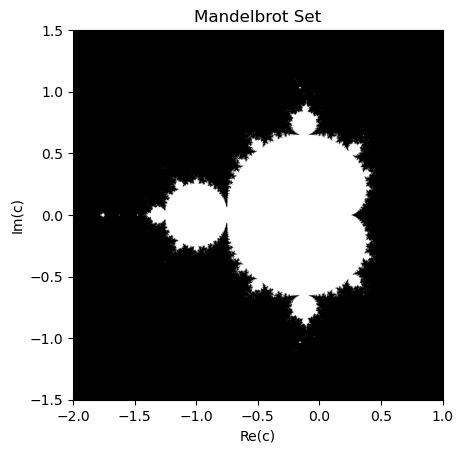

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter, threshold):

    x, y = np.mgrid[xmin:xmax:width*1j, ymin:ymax:height*1j]
    c = x + 1j*y
    z = np.zeros_like(c)

    mask = np.ones(c.shape, dtype = bool)

    for i in range (max_iter):
        z[mask] = z[mask] ** 2 + c[mask]
        mask[np.abs(z) > threshold] = False

    return mask


def main():
    width = 1000
    height = 1000
    xmin, xmax = -2.0, 1.0
    ymin, ymax = -1.5, 1.5
    max_iter = 50
    threshold = 100

    mandelbrot_mask = mandelbrot(xmin, xmax, ymin, ymax, width, height, max_iter, threshold)

    plt.imshow(mandelbrot_mask.T, extent=[-2, 1, -1.5, 1.5], origin='lower', cmap='gray')
    plt.title("Mandelbrot Set")
    plt.xlabel("Re(c)")
    plt.ylabel("Im(c)")
    plt.savefig("mandelbrot.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()